## Abstract

In this blog post, we implement the perceptron, one of the first machine learning models ever invented, and perform a few experiments to highlight the model's strengths and weaknesses.
The perceptron algorithm is used to predict a binary outcome on data with a continuous and finite-dimensional feature space.
Through our experiments, we visually illustrate that perceptron converges to a solution that completely differentiates between the outcome classes on linearly separable data.
However, the algorithm does not converge to a solution on non-linearly separable data.
We then implement a generalization of perceptron known as minibatch perceptron, which uses $k$ observations in each iteration rather than $1$.
We perform experiments that illustrate that minibatch perceptron behaves similarly to perceptron when $k = 1$ and continues to find a decision boundary on linearly separable data as we increase $k$ towards $n$.
Finally, we show that when $k = n$, minibatch perceptron can converge to a solution on non-linearly separable data, although this solution will not correctly classify every data point.
To see my implementation of the two algorithms, please visit [`perceptron.py`](perceptron.py) and [`minibatch_perceptron.py`](minibatch_perceptron.py).

## Part A: Implementing Perceptron

First, we implemented the perceptron algorithm in [`perceptron.py`](perceptron.py).
Recall from Professor Chodrow's [lecture notes](https://www.philchodrow.prof/ml-notes/chapters/20-perceptron.html#fig-demonstration) that the perceptron algorithm involves the following process:

1. Randomly select an initial decision boundary $\mathbf{w}^{(0)}$. 
2. Iteratively: 
    - Pick a random integer $i \in \{1,\ldots,n\}$. 
    - Compute the score for the point $i$: $s_i = \langle \mathbf{w}^{(t)}, \mathbf{x}_i \rangle$. 
    - Update the decision boundary: $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \mathbb{1} [s_i y_i < 0] y_i \mathbf{x}_i$ 

This entire process is implemented in [`perceptron.py`](perceptron.py), but for the sake of brevity, I will not discuss every line of code in this blog post.
Instead, I focus exclusively on my implementation of the `grad()` function, which calculates $\mathbb{1} [s_i y_i < 0] y_i \mathbf{x}_i$.


In [1]:
# grad() function from perceptron.py
def grad(self, X, y):
        s = X@self.w
        return (s*y < 0)*X*y

By taking advantage of our knowledge of linear algebra, the implementation of `grad()` becomes quite short!
In the first line of `grad()`, we calculate the inner product $s_i = \langle \mathbf{w}^{(t)}, \mathbf{x}_i \rangle$.
The tensors `X` and `self.w` are shaped appropriately for us to compute this inner product with `torch`'s `@` operator.
In the second and final line of `grad()`, we use our result from the first line to calculate $[s_i y_i < 0] y_i \mathbf{x}_i$.

To verify that our implementation of perceptron was succussful, we run the "minimal training loop" provided in the assignment instructions.
First, we need data to run the loop on, so we use some code generously provided by Professor Chodrow to generate and display our linearly separable data.

In [2]:
# import packages
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer
from minibatch_perceptron import MinibatchPerceptron, MinibatchPerceptronOptimizer
import torch
from matplotlib import pyplot as plt
import ipywidgets as wdg
plt.style.use('seaborn-v0_8-whitegrid')

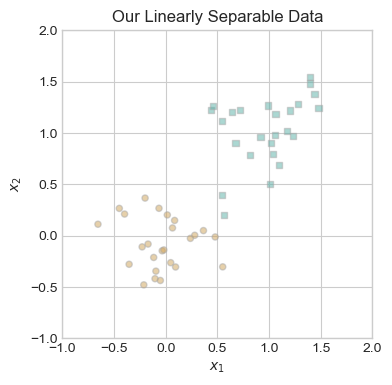

In [3]:
# define function to create data
def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

# define function to plot data
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# set seed
torch.manual_seed(1234)

# create linearly separable data
X_ls, y_ls = perceptron_data(n_points = 50, noise = 0.3)

# plot linearly separable data
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X_ls, y_ls, ax)
ax.set_title("Our Linearly Separable Data");

Visually, it is clear that one could draw a line between the two different colors of points, so our data is linearly separable.
This is important, because the perceptron algorithm will only converge to a solution with a loss of zero on linearly separable data.
Since we have our data, we are now prepared to run the minimal training loop. 

In [4]:
# set seed
torch.manual_seed(1234567)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

# define loss variable
loss = 1.0

# for keeping track of loss values
loss_vec = []

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_ls, y_ls) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_ls, y_ls)


The minimal training loop terminates, so our model must have converged to a solution with a loss of 0.

## Part B: Fitting and Evaluating Perceptron Models

Now that we have a functional implementation of perceptron, we perform experiments and generate illustrations to illustrate the strengths and weaknesses of the perceptron model.

### Part B.1: Evolution of the Model on Linearly Separable Data

First, we illustrate how the loss function changes between iterations of the minimal training loop.

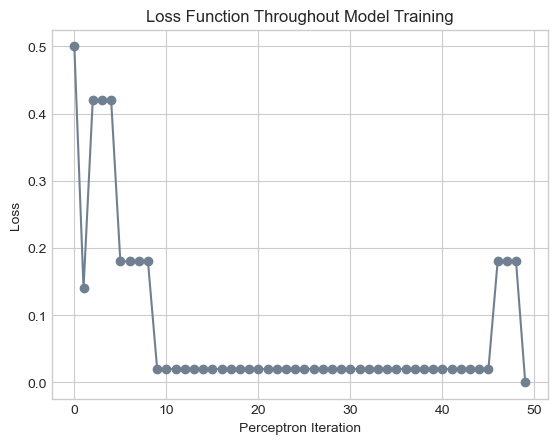

In [5]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

As you can see, our implementation of the perceptron algorithm converges to a solution with zero loss after 49 iterations.
Notice that throughout this process, the weight vector only changes 6 times.
In all 43 other iterations, the randomly selected point was correctly classified by the model at that stage.

To gain some insight as to the location and orientation of the decision boundary throughout this process, we plot the changes to weight vector in the figure below.
We include a subplot for every change to the weight vector, letting the dashed lines represent the previous weight vector and the solid lines represent the current weight vector.
In each subplot, the circled point corresponds to the point $i$ that was misclassified leading to the update in the weight vector.

Thank you to Professor Chodrow for providing the code for creating this visualization.

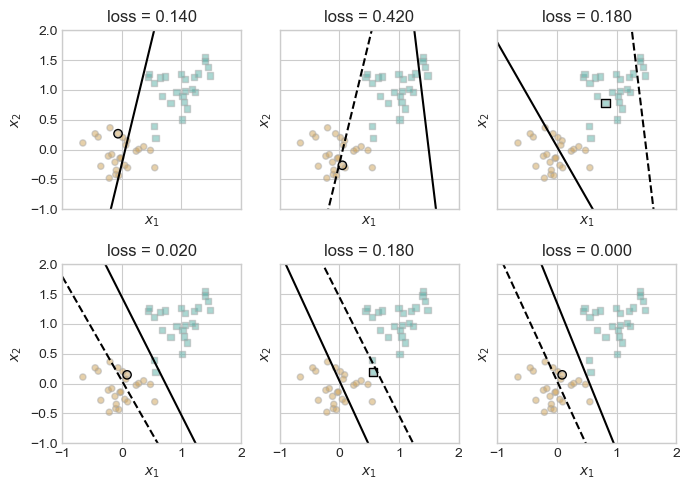

In [6]:
# define line function
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# set seed
torch.manual_seed(1234567)

# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X_ls, y_ls)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    i, local_loss = opt.step(X_ls, y_ls)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X_ls, y_ls, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X_ls, y_ls).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X_ls[i,0],X_ls[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y_ls[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

These figures illustrate how the model responds to the random selection of an incorrectly classified point.
Generally, the correction slightly overcompensates for the misclassified point, leading the decision boundary to fluctuate between which class it incorrectly classifies, gradually adjusting until it classifies all points correctly.

### Part B.2: Evolution of the Model on Non-Linearly Separable Data

Unfortunately, the perceptron algorithm will not converge to a decision boundary on data that is not linearly separable.
To illustrate this, we first need to create data that cannot be perfectly divided using one separating line.

To create our non-linearly separable data, we use the same method as before but increase the amount of noise.
As you can see in the graph below, the two classes have tendencies towards different regions in our resulting data, but it is impossible to draw a straight line that perfectly separates them.

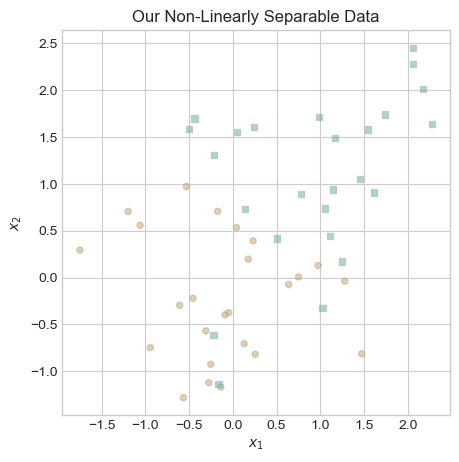

In [7]:
# set seed
torch.manual_seed(1234)

# create non-linearly separable data
X_nls, y_nls = perceptron_data(n_points = 50, noise = 0.8)

# plot non-linearly separable data
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
ax.set_title("Our Non-Linearly Separable Data");

Now that we have created non-linearly separable data, we fit the perceptron model on our data.
Since the perceptron will not converge to a solution on our data, we modify our code so the model terminates after 1000 iterations.

In [8]:
# set seed
torch.manual_seed(1234567)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

# define loss variable
loss = 1.0

# for keeping track of loss values
loss_vec = []

# for recording iteration number
iter = 0

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_nls, y_nls) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_nls, y_nls)

    # update iter
    iter += 1

    # maxiter condition
    if iter >= 1000:
        break


As before, we begin by inspecting the change in loss over the iterations of our algorithm.

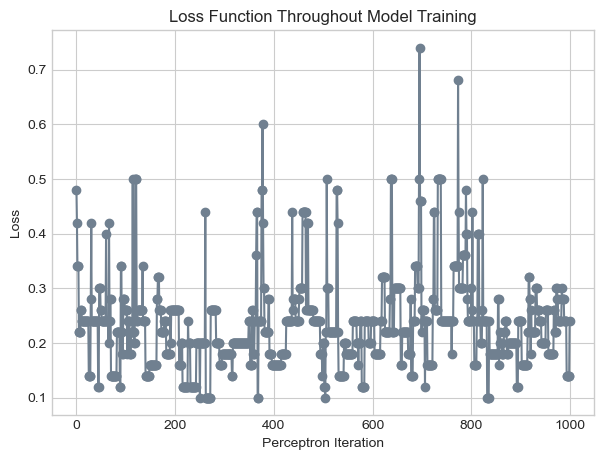

In [9]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

In the figure above, our model clearly does not converge to a solution.
Rather, the perceptron algorithm is so sensitive to the individual data point under consideration at any given moment that the loss fluctuates wildly throughout the entire process, ranging from less than 0.1 to more than 0.7.

In the linearly separable case, we visually inspected every change to the weight vector, but because there are so many changes to the model in this case, it would be burdensome to inspect every change.
Instead, we display the decision boundary in the final iteration of our model.

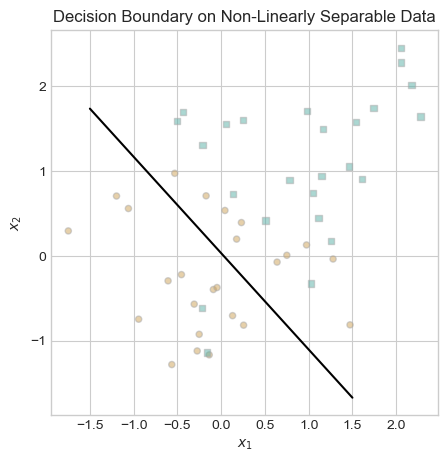

In [10]:
# Plot final decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
draw_line(p.w, x_min = -1.5, x_max = 1.5, ax = ax, color = "black")
ax.set_title("Decision Boundary on Non-Linearly Separable Data");

The decision boundary could be worse, but it is far from perfect.
The inadequate performance on non-linearly separable data is a major weakness of the perceptron algorithm.

### Part B.3: A 5-Dimensional Example 

Up until this point, we have only trained perceptron models on 2-dimensional data.
Working with 2-dimensional data facilitates understanding and communication surrounding the model, as we can easily visualize data in two dimensions.
However, we wrote our model to work in any finite number of dimensions.
To demonstrate that our implementation works on multidimensional data, we now fit a perceptron model on data with 5 features.

In [11]:
# set seed
torch.manual_seed(1234)

# create data
X_5d, y_5d = perceptron_data(n_points = 50, noise = 0.3, p_dims = 5)

# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

# define loss variable
loss = 1.0

# for keeping track of loss values
loss_vec = []

# for recording iteration number
iter = 0

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X_5d, y_5d) 
    loss_vec.append(loss)
    
    # perform a perceptron update using the random data point
    opt.step(X_5d, y_5d)

    iter += 1
    if iter >= 1000:
        break


While we cannot visualize our 5 dimensional data and weight vector, we can inspect the changes to our loss function over time using the plot below.

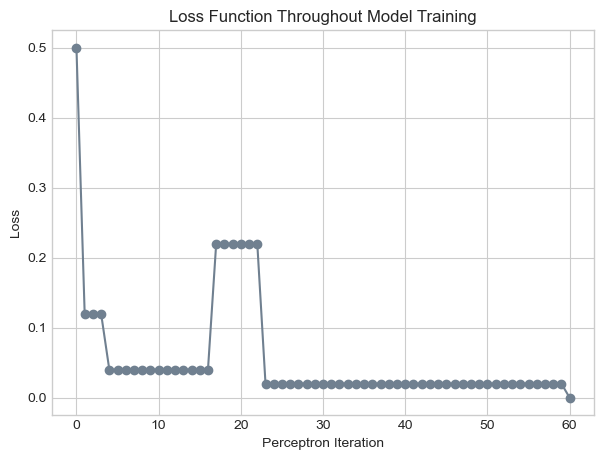

In [12]:
# plot the changes in loss 
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration", ylabel = "Loss")
plt.title("Loss Function Throughout Model Training");

In the figure above, it appears that the perceptron algorithm terminated after 60 iterations, achieving a loss value of zero.
The perceptron algorithm terminates if and only if its training data is linearly separable; thus, our data must be linearly separable.

## Part C: Minibatch Perceptron

In this section, I implemented an extension to perceptron known as minibatch perceptron.
The minibatch perceptron algorithm differs from the perceptron algorithm in that instead of updating the decision boundary using $1$ random point, it updates the decision boundary using $k$ random points.
In more detail, the algorithm involves the following process:

1. Randomly select an initial decision boundary $\mathbf{w}^{(0)}$. 
2. Iteratively: 
    - Sample $k$ random integers $i_1, i_2, ..., i_k \in \{1,\ldots,n\}$ without replacement. 
    - Update the decision boundary: $$\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} + \frac{\alpha}{k} \sum_{j=1}^k \mathbb{1} [\langle \mathbf{w}^{(t)}, \mathbf{x}_{i_j} \rangle y_{i_j} < 0] y_{i_j} \mathbf{x}_{i_j} $$ 

You can view my implementation of the algorithm at [`minibatch_perceptron.py`](minibatch_perceptron.py), but I will not discuss all of the implementation details here.
From the user's perspective, fitting a minibatch perceptron model is exactly the same as fitting the perceptron model, with the addition of two parameters: $k$ and $\alpha$.
The $k$ parameter simply refers to the number of points used in each iteration, while the $\alpha$ parameter is a learning rate that affects how much $\mathbf{w}$ changes when updated.

In the rest of this section, we perform a few experiments to illustrate the functionality of our algorithm and its similarities and differences in comparison to the regular perceptron algorithm.
The experiments we perform in parts `C.1`, `C.2`, and `C.3` all involve relatively similar operations.
To reduce the volume of code in each section, we define the `experiment()` function below.

In [13]:
def experiment(X, y, k, alpha):  
    # set seed
    torch.manual_seed(1234567)

    # instantiate a model and an optimizer
    mb_p = MinibatchPerceptron() 
    mb_opt = MinibatchPerceptronOptimizer(mb_p)

    # define loss variable
    mb_loss = 1.0

    # for keeping track of loss values
    mb_loss_vec = []

    # for recording iteration number
    iter = 0

    while mb_loss > 0: # dangerous -- only terminates if data is linearly separable
        
        # not part of the update: just for tracking our progress    
        mb_loss = mb_p.loss(X, y) 
        mb_loss_vec.append(mb_loss)
        
        # perform a perceptron update using the random data point
        mb_opt.step(X, y, k, alpha)

        # update iter
        iter += 1

        # maxiter condition
        if iter >= 1000:
            break
    
    # set seed
    torch.manual_seed(1234567)

    # instantiate a model and an optimizer
    p = Perceptron() 
    opt = PerceptronOptimizer(p)

    # define loss variable
    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    # for recording iteration number
    iter = 0

    while loss > 0: # dangerous -- only terminates if data is linearly separable
        
        # not part of the update: just for tracking our progress    
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # perform a perceptron update using the random data point
        opt.step(X, y)

        # update iter
        iter += 1

        # maxiter condition
        if iter >= 1000:
            break
    
    return loss_vec, mb_loss_vec, p.w, mb_p.w


### Part C.1: When k = 1

To illustrate the differences between the perceptron and minibatch perceptron algorithms, we begin by fitting the regular perceptron and the minibatch perceptron with $k = \alpha = 1$ on our linearly separable data.

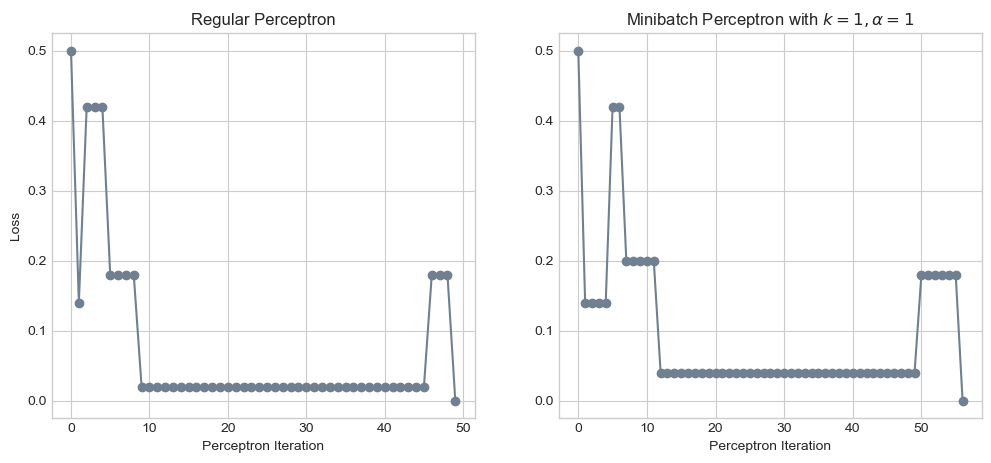

In [14]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_ls, y = y_ls, k = 1, alpha = 1)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels 
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 1, \\alpha = 1$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");


The two algorithms generated incredibly similar results!
In fact, if the random point considered at iteration had been the same, these graphs would be identical.
In the regular perceptron algorithm, we generate a random number between $0$ and $n$, but in the minibatch perceptron algorithm, we generate a random permutation of the numbers $0$ through $n-1$ and select the first element of that permutation.
This difference appears to result in different points being considered at each iteration, explaining why these graphs differ slightly.

### Part C.2: When k = 10

One advantage of the minibatch perceptron is that we can tune our model to different values of $k$ and $\alpha$.
As our first adjustment, let's try changing $k$ to $10$.

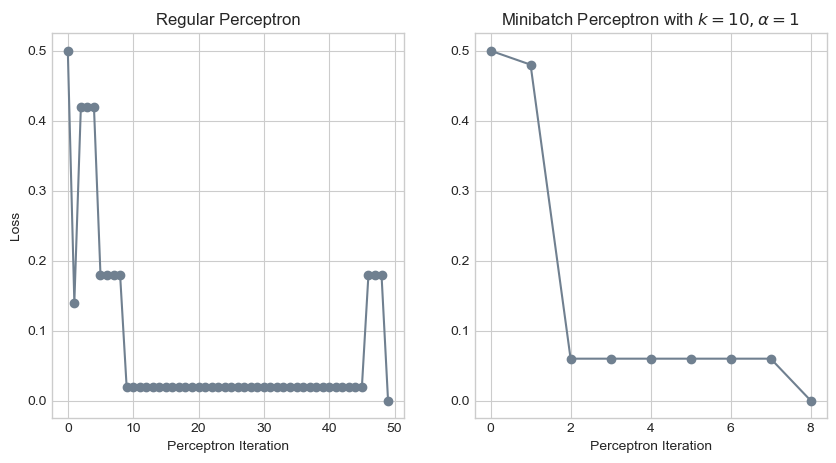

In [15]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_ls, y = y_ls, k = 10, alpha = 1)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 10, \\alpha = 1$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

It appears that this adjustment allowed our model to converge to a decision boundary in far fewer iterations!
While our regular perceptron model requires 49 iterations to achieve perfect classification, the minibatch model with $k = 10$ requires only 8 iterations.

### Part C.2: Convergence on Non-Linearly Separable Data

Another advantage of the minibatch perceptron model is that it can converge to a decision threshold on data that is not linearly separable!
This does not mean that the model will perfectly classify every data point, but rather that the model will converge to a loss value that is less than 0.5.

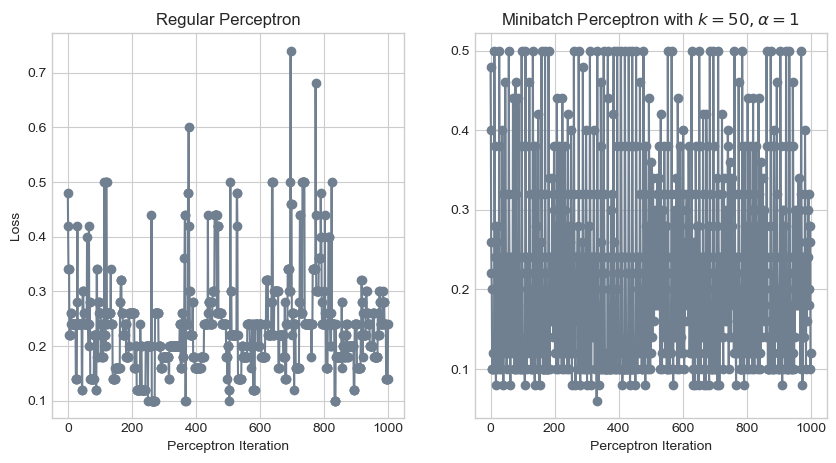

In [16]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_nls, y = y_nls, k = 50, alpha = 1)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 50, \\alpha = 1$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

Oh my! That certainly didn't work.
The minibatch perceptron model seems to have an even more chaotic loss function than the regular one!
This is why we have the hyperparameter $\alpha$.
Let's try decreasing $\alpha$ to 0.01.

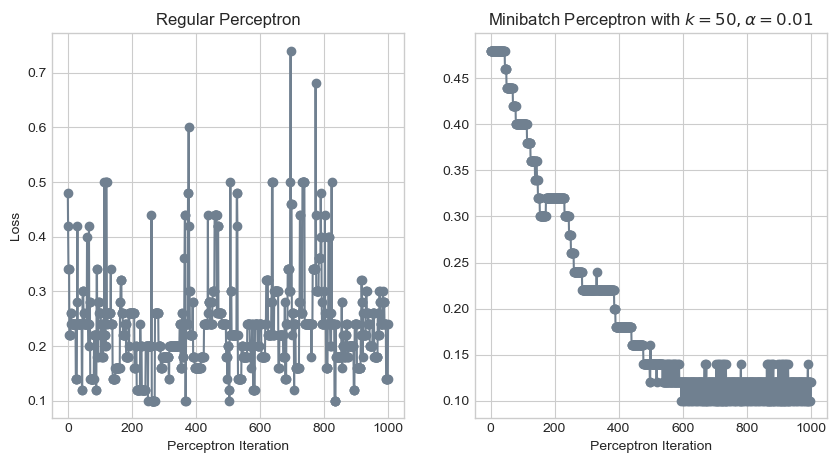

In [17]:
# Fit models
loss_vec, mb_loss_vec, p_w, mb_p_w = experiment(X = X_nls, y = y_nls, k = 50, alpha = 0.01)

# Create plots
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(loss_vec, color = "slategrey")
ax[0].scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
ax[1].plot(mb_loss_vec, color = "slategrey")
ax[1].scatter(torch.arange(len(mb_loss_vec)), mb_loss_vec, color = "slategrey")

# Add labels
ax[0].set_title("Regular Perceptron")
ax[1].set_title("Minibatch Perceptron with $k = 50, \\alpha = 0.01$")
ax[0].set_xlabel("Perceptron Iteration")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Perceptron Iteration");

Phew, that looks much better!
Whereas the loss function of the regular perceptron algorithm would oscillate for an eternity, the loss function of the minibatch algorithm converged to a value between 0.1 and 0.15 by the 600th iteration.
Let's take a look at the resulting decision boundary.

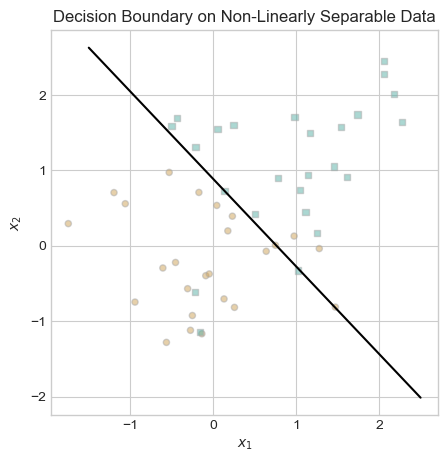

In [18]:
# Plot final decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_perceptron_data(X_nls, y_nls, ax)
draw_line(mb_p_w, x_min = -1.5, x_max = 2.5, ax = ax, color = "black")
# ax.set(xlim = (-1, 2), ylim = (-1, 2))
ax.set_title("Decision Boundary on Non-Linearly Separable Data");

This decision boundary looks great!
Obviously, it is impossible to perfectly separate the two categories of data in this example with a straight line.
The decision boundary that our minibatch perceptron algorithm converged to appears to be about as good as we can do.

## Part D: Runtime Complexity

What is the runtime complexity of perceptron and minibatch perceptron?
To answer this question, let us consider the three lines of code that we run in each iteration of the model:

```{python}
loss = p.loss(X, y) 
loss_vec.append(loss)
opt.step(X, y)
```

The first two lines store a record of the loss function for tracking purposes.
They are not actually required for fitting the perceptron, so we exclude them from our consideration of the algorithm's runtime complexity.
Thus evaluating the runtime complexity of a single iteration of perceptron amounts to evaluating the runtime complexity of `opt.step(X, y)`.

In our implementation of perceptron (see [`perceptron.py`](perceptron.py)), `opt.step()` involves the following operations:
- `n = X.size()[0]`: determines the number of rows in `X` in constant time 
- `i = torch.randint(n, size = (1,))`: selects a random integer in constant time
- `x_i = X[[i],:]` and `y_i = y[i]`: subsets `X` and `y` in constant time
- `current_loss = self.model.loss(X, y)`: calculates the current loss, which involves a dot product between two $1 \times p$ vectors, an operation with linear time complexity O($p$)
- `self.model.w += torch.reshape(self.model.grad(x_i, y_i),(self.model.w.size()[0],))`: updates $\mathbf{w}$ in linear time due to a dot product in the `grad` function
- `new_loss = self.model.loss(X, y)`: calculates the updated loss in linear time due to a dot product
- `return i, abs(current_loss - new_loss)`: returns values for visualization in constant time

Since the operations with the largest time complexity were O($p$), the overall runtime complexity of a single iteration of the perceptron algorithm is O($p$).
This runtime depends on the number of features $p$ rather than the number of observations $n$, because the dot product is between the weight vector $\mathbf{w}$ and a single row of $X$.

In our implementation of minibatch perceptron (see [`minibatch_perceptron.py`](minibatch_perceptron.py)), `opt.step()` involves largely similar operations.
The only difference in runtime occurs in the `grad()` function.
Whereas in the regular perceptron, this involved computing a single dot product between two $1 \times p$ vectors, in the minibatch perceptron, this involves computing a matrix product between $X^{k \times p}$ and $w^{p \times 1}$.
Calculating this matrix product is equivalent to calculating $k$ dot products, each of which are O($p$).
Thus the runtime of the matrix product, and therefore the big O runtime of the minibatch perceptron algorithm, is O($kp$).


## Conclusion

In this assignment, we investigated the perceptron algorithm, implementing it from scratch within the object-oriented framework provided by Professor Chodrow.
We illustrated that the algorithm converges to a solution on linearly separable data of any finite number of dimensions but fails to converge to a solution on non-linearly separable data.
To address this shortcoming, we implemented the minibatch perceptron algorithm.
We found that when $k = 1$, minibatch perceptron is similar to regular perceptron, and as we increase $k$, the algorithm continues to find decision boundaries on linearly separable data.
Furthermore, we discovered that when $k = n$ and our learning rate $\alpha$ is adjusted appropriately, minibatch perceptron can converge to a (albeit imperfect) solution on data that is not linearly separable.
Overall, this assignment provided me with a great opportunity to write up my first machine learning model from scratch and investigate its strengths and weaknesses.